# Import stuff

In [3]:
%matplotlib inline
# Normal stuff
import os
import json
import glob
import shutil
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Pytorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision stuff
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Initialize dataset, parameters and network arcitecthure

In [84]:
# Datasets
training_data = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

validation_data = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=transforms.ToTensor())


# Default optimization parameters
exp_params = {
    'epochs': 100,
    'batch_size': 10,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'save_frequency': 100,
    'train_indices': np.arange(len(training_data)).tolist()
}


# Default network architecture
img_size = 28
# Conv layer 1
filter_size1 = 5
num_filter1  =16
pool_size1 = 2

# Conv layer 2
filter_size2 = 5
num_filter2 =36
pool_size2 = 2

# Fully connected layer
lin_input_size = int( img_size**2 * num_filter2 / (pool_size1**2 * pool_size2**2) )
num_neuron =  128
num_classes = 10


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filter1, kernel_size=filter_size1,padding=filter_size1//2)
        self.conv2 = nn.Conv2d(num_filter1, num_filter2, kernel_size=filter_size2,padding=filter_size2//2)
        self.relu  = nn.ReLU()
        self.fc1 = nn.Linear(lin_input_size, num_neuron)
        self.fc2 = nn.Linear(num_neuron, num_classes)

    def forward(self, x):
        x=self.conv1(x)
        x= F.max_pool2d(x,pool_size1)
        w1=self.relu(x)
        x = self.conv2(w1)
        x=self.relu(x)
        w2=F.max_pool2d(x,pool_size2)
        x = w2.view(-1, lin_input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return (x,w1,w2)

# Run experiment

In [126]:
def new_experiment(exp_params, exp_path=None):
    print("__NEW EXPERIMENT__")  
    
    if not exp_path:
        exp_path = os.path.join("exps", datetime.datetime.now().strftime("%Y_%M_%d-%T"))
        
    try:
        shutil.rmtree(exp_path)
    except:
        print("Not a path to delete")
    os.mkdir(exp_path)
    os.mkdir(os.path.join(exp_path, "models"))
    
    # Dump parameters for experiment for later reference
    with open(os.path.join(exp_path, "params.json"), 'w') as fp:
        json.dump(exp_params, fp, indent=4)
    
    
    # Define model and optimizer
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=exp_params['learning_rate'], momentum=exp_params['momentum'])
    criterion = nn.CrossEntropyLoss()
    
    # Get training data
    exp_training_data = torch.utils.data.Subset(all_training_data, exp_params['train_indices'])
    train_loader = torch.utils.data.DataLoader(dataset=exp_training_data,
                                           batch_size=exp_params['batch_size'], 
                                           shuffle=True)    
    n_batches = len(train_loader)

    # Start training loop
    for epoch in range(exp_params['epochs']):
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            # Save model on a given frequency
            n_updates = i + epoch*n_batches
            if n_updates % exp_params['save_frequency'] == 0:
                torch.save(model.state_dict(), os.path.join(exp_path, "models",
                                                            f"{epoch:0{len(str(exp_params['epochs']))}}_{i:0{len(str(n_batches))}}.pt"))
                
            
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs[0], labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            
            if  (i+1) % (n_batches/10) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, exp_params['epochs'], i+1, n_batches, loss.item()))     
                
            
# Possibility to change some exp params
exp_params['epochs'] = 1000
exp_params['save_frequency'] = 1
exp_params['train_indices'] = np.random.choice(len(all_training_data), (50, )).tolist()
exp_path = os.path.join("exps", "test") 
new_experiment(exp_params, exp_path)

__NEW EXPERIMENT__
Epoch [1/1000], Step [1/5], Loss: 2.3046
Epoch [1/1000], Step [2/5], Loss: 2.3314
Epoch [1/1000], Step [3/5], Loss: 2.3071
Epoch [1/1000], Step [4/5], Loss: 2.2758
Epoch [1/1000], Step [5/5], Loss: 2.2912
Epoch [2/1000], Step [1/5], Loss: 2.3046
Epoch [2/1000], Step [2/5], Loss: 2.3075
Epoch [2/1000], Step [3/5], Loss: 2.3215
Epoch [2/1000], Step [4/5], Loss: 2.2773
Epoch [2/1000], Step [5/5], Loss: 2.2828
Epoch [3/1000], Step [1/5], Loss: 2.3132
Epoch [3/1000], Step [2/5], Loss: 2.2868
Epoch [3/1000], Step [3/5], Loss: 2.2957
Epoch [3/1000], Step [4/5], Loss: 2.2923
Epoch [3/1000], Step [5/5], Loss: 2.2757
Epoch [4/1000], Step [1/5], Loss: 2.2915
Epoch [4/1000], Step [2/5], Loss: 2.2665
Epoch [4/1000], Step [3/5], Loss: 2.2956
Epoch [4/1000], Step [4/5], Loss: 2.2896
Epoch [4/1000], Step [5/5], Loss: 2.2906
Epoch [5/1000], Step [1/5], Loss: 2.2846
Epoch [5/1000], Step [2/5], Loss: 2.2968
Epoch [5/1000], Step [3/5], Loss: 2.2853
Epoch [5/1000], Step [4/5], Loss: 2.26

Epoch [40/1000], Step [4/5], Loss: 1.8113
Epoch [40/1000], Step [5/5], Loss: 1.5415
Epoch [41/1000], Step [1/5], Loss: 1.6192
Epoch [41/1000], Step [2/5], Loss: 1.6365
Epoch [41/1000], Step [3/5], Loss: 1.0206
Epoch [41/1000], Step [4/5], Loss: 1.5038
Epoch [41/1000], Step [5/5], Loss: 1.5118
Epoch [42/1000], Step [1/5], Loss: 1.4300
Epoch [42/1000], Step [2/5], Loss: 1.2657
Epoch [42/1000], Step [3/5], Loss: 1.2386
Epoch [42/1000], Step [4/5], Loss: 1.6570
Epoch [42/1000], Step [5/5], Loss: 1.3830
Epoch [43/1000], Step [1/5], Loss: 1.3467
Epoch [43/1000], Step [2/5], Loss: 1.4850
Epoch [43/1000], Step [3/5], Loss: 1.1487
Epoch [43/1000], Step [4/5], Loss: 1.3698
Epoch [43/1000], Step [5/5], Loss: 1.3220
Epoch [44/1000], Step [1/5], Loss: 1.0632
Epoch [44/1000], Step [2/5], Loss: 1.5013
Epoch [44/1000], Step [3/5], Loss: 1.6013
Epoch [44/1000], Step [4/5], Loss: 0.9082
Epoch [44/1000], Step [5/5], Loss: 1.2593
Epoch [45/1000], Step [1/5], Loss: 1.6042
Epoch [45/1000], Step [2/5], Loss:

Epoch [87/1000], Step [5/5], Loss: 0.0798
Epoch [88/1000], Step [1/5], Loss: 0.1660
Epoch [88/1000], Step [2/5], Loss: 0.0776
Epoch [88/1000], Step [3/5], Loss: 0.1394
Epoch [88/1000], Step [4/5], Loss: 0.0746
Epoch [88/1000], Step [5/5], Loss: 0.2005
Epoch [89/1000], Step [1/5], Loss: 0.1784
Epoch [89/1000], Step [2/5], Loss: 0.1218
Epoch [89/1000], Step [3/5], Loss: 0.1726
Epoch [89/1000], Step [4/5], Loss: 0.0344
Epoch [89/1000], Step [5/5], Loss: 0.1486
Epoch [90/1000], Step [1/5], Loss: 0.0779
Epoch [90/1000], Step [2/5], Loss: 0.1094
Epoch [90/1000], Step [3/5], Loss: 0.1721
Epoch [90/1000], Step [4/5], Loss: 0.0665
Epoch [90/1000], Step [5/5], Loss: 0.2059
Epoch [91/1000], Step [1/5], Loss: 0.0759
Epoch [91/1000], Step [2/5], Loss: 0.0617
Epoch [91/1000], Step [3/5], Loss: 0.1726
Epoch [91/1000], Step [4/5], Loss: 0.0445
Epoch [91/1000], Step [5/5], Loss: 0.1728
Epoch [92/1000], Step [1/5], Loss: 0.0716
Epoch [92/1000], Step [2/5], Loss: 0.2020
Epoch [92/1000], Step [3/5], Loss:

Epoch [127/1000], Step [4/5], Loss: 0.0504
Epoch [127/1000], Step [5/5], Loss: 0.0294
Epoch [128/1000], Step [1/5], Loss: 0.0296
Epoch [128/1000], Step [2/5], Loss: 0.0196
Epoch [128/1000], Step [3/5], Loss: 0.0471
Epoch [128/1000], Step [4/5], Loss: 0.0259
Epoch [128/1000], Step [5/5], Loss: 0.0510
Epoch [129/1000], Step [1/5], Loss: 0.0286
Epoch [129/1000], Step [2/5], Loss: 0.0389
Epoch [129/1000], Step [3/5], Loss: 0.0315
Epoch [129/1000], Step [4/5], Loss: 0.0131
Epoch [129/1000], Step [5/5], Loss: 0.0641
Epoch [130/1000], Step [1/5], Loss: 0.0551
Epoch [130/1000], Step [2/5], Loss: 0.0376
Epoch [130/1000], Step [3/5], Loss: 0.0135
Epoch [130/1000], Step [4/5], Loss: 0.0322
Epoch [130/1000], Step [5/5], Loss: 0.0353
Epoch [131/1000], Step [1/5], Loss: 0.0172
Epoch [131/1000], Step [2/5], Loss: 0.0593
Epoch [131/1000], Step [3/5], Loss: 0.0333
Epoch [131/1000], Step [4/5], Loss: 0.0364
Epoch [131/1000], Step [5/5], Loss: 0.0122
Epoch [132/1000], Step [1/5], Loss: 0.0296
Epoch [132/

Epoch [173/1000], Step [2/5], Loss: 0.0262
Epoch [173/1000], Step [3/5], Loss: 0.0075
Epoch [173/1000], Step [4/5], Loss: 0.0098
Epoch [173/1000], Step [5/5], Loss: 0.0126
Epoch [174/1000], Step [1/5], Loss: 0.0140
Epoch [174/1000], Step [2/5], Loss: 0.0132
Epoch [174/1000], Step [3/5], Loss: 0.0112
Epoch [174/1000], Step [4/5], Loss: 0.0164
Epoch [174/1000], Step [5/5], Loss: 0.0122
Epoch [175/1000], Step [1/5], Loss: 0.0023
Epoch [175/1000], Step [2/5], Loss: 0.0221
Epoch [175/1000], Step [3/5], Loss: 0.0093
Epoch [175/1000], Step [4/5], Loss: 0.0300
Epoch [175/1000], Step [5/5], Loss: 0.0049
Epoch [176/1000], Step [1/5], Loss: 0.0112
Epoch [176/1000], Step [2/5], Loss: 0.0190
Epoch [176/1000], Step [3/5], Loss: 0.0125
Epoch [176/1000], Step [4/5], Loss: 0.0175
Epoch [176/1000], Step [5/5], Loss: 0.0075
Epoch [177/1000], Step [1/5], Loss: 0.0176
Epoch [177/1000], Step [2/5], Loss: 0.0029
Epoch [177/1000], Step [3/5], Loss: 0.0171
Epoch [177/1000], Step [4/5], Loss: 0.0095
Epoch [177/

Epoch [214/1000], Step [1/5], Loss: 0.0131
Epoch [214/1000], Step [2/5], Loss: 0.0078
Epoch [214/1000], Step [3/5], Loss: 0.0065
Epoch [214/1000], Step [4/5], Loss: 0.0054
Epoch [214/1000], Step [5/5], Loss: 0.0065
Epoch [215/1000], Step [1/5], Loss: 0.0099
Epoch [215/1000], Step [2/5], Loss: 0.0082
Epoch [215/1000], Step [3/5], Loss: 0.0019
Epoch [215/1000], Step [4/5], Loss: 0.0100
Epoch [215/1000], Step [5/5], Loss: 0.0090
Epoch [216/1000], Step [1/5], Loss: 0.0074
Epoch [216/1000], Step [2/5], Loss: 0.0148
Epoch [216/1000], Step [3/5], Loss: 0.0026
Epoch [216/1000], Step [4/5], Loss: 0.0091
Epoch [216/1000], Step [5/5], Loss: 0.0047
Epoch [217/1000], Step [1/5], Loss: 0.0084
Epoch [217/1000], Step [2/5], Loss: 0.0070
Epoch [217/1000], Step [3/5], Loss: 0.0076
Epoch [217/1000], Step [4/5], Loss: 0.0089
Epoch [217/1000], Step [5/5], Loss: 0.0061
Epoch [218/1000], Step [1/5], Loss: 0.0127
Epoch [218/1000], Step [2/5], Loss: 0.0040
Epoch [218/1000], Step [3/5], Loss: 0.0039
Epoch [218/

Epoch [259/1000], Step [1/5], Loss: 0.0041
Epoch [259/1000], Step [2/5], Loss: 0.0050
Epoch [259/1000], Step [3/5], Loss: 0.0058
Epoch [259/1000], Step [4/5], Loss: 0.0019
Epoch [259/1000], Step [5/5], Loss: 0.0089
Epoch [260/1000], Step [1/5], Loss: 0.0062
Epoch [260/1000], Step [2/5], Loss: 0.0028
Epoch [260/1000], Step [3/5], Loss: 0.0012
Epoch [260/1000], Step [4/5], Loss: 0.0101
Epoch [260/1000], Step [5/5], Loss: 0.0052
Epoch [261/1000], Step [1/5], Loss: 0.0032
Epoch [261/1000], Step [2/5], Loss: 0.0076
Epoch [261/1000], Step [3/5], Loss: 0.0084
Epoch [261/1000], Step [4/5], Loss: 0.0060
Epoch [261/1000], Step [5/5], Loss: 0.0005
Epoch [262/1000], Step [1/5], Loss: 0.0041
Epoch [262/1000], Step [2/5], Loss: 0.0065
Epoch [262/1000], Step [3/5], Loss: 0.0073
Epoch [262/1000], Step [4/5], Loss: 0.0037
Epoch [262/1000], Step [5/5], Loss: 0.0035
Epoch [263/1000], Step [1/5], Loss: 0.0064
Epoch [263/1000], Step [2/5], Loss: 0.0053
Epoch [263/1000], Step [3/5], Loss: 0.0024
Epoch [263/

Epoch [299/1000], Step [2/5], Loss: 0.0061
Epoch [299/1000], Step [3/5], Loss: 0.0024
Epoch [299/1000], Step [4/5], Loss: 0.0030
Epoch [299/1000], Step [5/5], Loss: 0.0061
Epoch [300/1000], Step [1/5], Loss: 0.0023
Epoch [300/1000], Step [2/5], Loss: 0.0061
Epoch [300/1000], Step [3/5], Loss: 0.0028
Epoch [300/1000], Step [4/5], Loss: 0.0060
Epoch [300/1000], Step [5/5], Loss: 0.0017
Epoch [301/1000], Step [1/5], Loss: 0.0036
Epoch [301/1000], Step [2/5], Loss: 0.0063
Epoch [301/1000], Step [3/5], Loss: 0.0019
Epoch [301/1000], Step [4/5], Loss: 0.0018
Epoch [301/1000], Step [5/5], Loss: 0.0054
Epoch [302/1000], Step [1/5], Loss: 0.0035
Epoch [302/1000], Step [2/5], Loss: 0.0034
Epoch [302/1000], Step [3/5], Loss: 0.0040
Epoch [302/1000], Step [4/5], Loss: 0.0055
Epoch [302/1000], Step [5/5], Loss: 0.0024
Epoch [303/1000], Step [1/5], Loss: 0.0034
Epoch [303/1000], Step [2/5], Loss: 0.0065
Epoch [303/1000], Step [3/5], Loss: 0.0057
Epoch [303/1000], Step [4/5], Loss: 0.0014
Epoch [303/

Epoch [340/1000], Step [1/5], Loss: 0.0013
Epoch [340/1000], Step [2/5], Loss: 0.0065
Epoch [340/1000], Step [3/5], Loss: 0.0020
Epoch [340/1000], Step [4/5], Loss: 0.0014
Epoch [340/1000], Step [5/5], Loss: 0.0037
Epoch [341/1000], Step [1/5], Loss: 0.0029
Epoch [341/1000], Step [2/5], Loss: 0.0028
Epoch [341/1000], Step [3/5], Loss: 0.0003
Epoch [341/1000], Step [4/5], Loss: 0.0014
Epoch [341/1000], Step [5/5], Loss: 0.0076
Epoch [342/1000], Step [1/5], Loss: 0.0017
Epoch [342/1000], Step [2/5], Loss: 0.0022
Epoch [342/1000], Step [3/5], Loss: 0.0037
Epoch [342/1000], Step [4/5], Loss: 0.0035
Epoch [342/1000], Step [5/5], Loss: 0.0037
Epoch [343/1000], Step [1/5], Loss: 0.0047
Epoch [343/1000], Step [2/5], Loss: 0.0021
Epoch [343/1000], Step [3/5], Loss: 0.0025
Epoch [343/1000], Step [4/5], Loss: 0.0028
Epoch [343/1000], Step [5/5], Loss: 0.0028
Epoch [344/1000], Step [1/5], Loss: 0.0036
Epoch [344/1000], Step [2/5], Loss: 0.0022
Epoch [344/1000], Step [3/5], Loss: 0.0022
Epoch [344/

Epoch [385/1000], Step [1/5], Loss: 0.0016
Epoch [385/1000], Step [2/5], Loss: 0.0031
Epoch [385/1000], Step [3/5], Loss: 0.0016
Epoch [385/1000], Step [4/5], Loss: 0.0038
Epoch [385/1000], Step [5/5], Loss: 0.0020
Epoch [386/1000], Step [1/5], Loss: 0.0027
Epoch [386/1000], Step [2/5], Loss: 0.0010
Epoch [386/1000], Step [3/5], Loss: 0.0024
Epoch [386/1000], Step [4/5], Loss: 0.0035
Epoch [386/1000], Step [5/5], Loss: 0.0024
Epoch [387/1000], Step [1/5], Loss: 0.0016
Epoch [387/1000], Step [2/5], Loss: 0.0015
Epoch [387/1000], Step [3/5], Loss: 0.0032
Epoch [387/1000], Step [4/5], Loss: 0.0016
Epoch [387/1000], Step [5/5], Loss: 0.0040
Epoch [388/1000], Step [1/5], Loss: 0.0038
Epoch [388/1000], Step [2/5], Loss: 0.0025
Epoch [388/1000], Step [3/5], Loss: 0.0016
Epoch [388/1000], Step [4/5], Loss: 0.0022
Epoch [388/1000], Step [5/5], Loss: 0.0016
Epoch [389/1000], Step [1/5], Loss: 0.0021
Epoch [389/1000], Step [2/5], Loss: 0.0022
Epoch [389/1000], Step [3/5], Loss: 0.0031
Epoch [389/

Epoch [428/1000], Step [1/5], Loss: 0.0025
Epoch [428/1000], Step [2/5], Loss: 0.0006
Epoch [428/1000], Step [3/5], Loss: 0.0023
Epoch [428/1000], Step [4/5], Loss: 0.0024
Epoch [428/1000], Step [5/5], Loss: 0.0021
Epoch [429/1000], Step [1/5], Loss: 0.0014
Epoch [429/1000], Step [2/5], Loss: 0.0033
Epoch [429/1000], Step [3/5], Loss: 0.0002
Epoch [429/1000], Step [4/5], Loss: 0.0027
Epoch [429/1000], Step [5/5], Loss: 0.0023
Epoch [430/1000], Step [1/5], Loss: 0.0015
Epoch [430/1000], Step [2/5], Loss: 0.0013
Epoch [430/1000], Step [3/5], Loss: 0.0021
Epoch [430/1000], Step [4/5], Loss: 0.0031
Epoch [430/1000], Step [5/5], Loss: 0.0019
Epoch [431/1000], Step [1/5], Loss: 0.0018
Epoch [431/1000], Step [2/5], Loss: 0.0014
Epoch [431/1000], Step [3/5], Loss: 0.0014
Epoch [431/1000], Step [4/5], Loss: 0.0026
Epoch [431/1000], Step [5/5], Loss: 0.0026
Epoch [432/1000], Step [1/5], Loss: 0.0005
Epoch [432/1000], Step [2/5], Loss: 0.0024
Epoch [432/1000], Step [3/5], Loss: 0.0031
Epoch [432/

Epoch [470/1000], Step [5/5], Loss: 0.0025
Epoch [471/1000], Step [1/5], Loss: 0.0020
Epoch [471/1000], Step [2/5], Loss: 0.0019
Epoch [471/1000], Step [3/5], Loss: 0.0023
Epoch [471/1000], Step [4/5], Loss: 0.0002
Epoch [471/1000], Step [5/5], Loss: 0.0021
Epoch [472/1000], Step [1/5], Loss: 0.0012
Epoch [472/1000], Step [2/5], Loss: 0.0022
Epoch [472/1000], Step [3/5], Loss: 0.0019
Epoch [472/1000], Step [4/5], Loss: 0.0007
Epoch [472/1000], Step [5/5], Loss: 0.0025
Epoch [473/1000], Step [1/5], Loss: 0.0013
Epoch [473/1000], Step [2/5], Loss: 0.0032
Epoch [473/1000], Step [3/5], Loss: 0.0015
Epoch [473/1000], Step [4/5], Loss: 0.0014
Epoch [473/1000], Step [5/5], Loss: 0.0011
Epoch [474/1000], Step [1/5], Loss: 0.0005
Epoch [474/1000], Step [2/5], Loss: 0.0013
Epoch [474/1000], Step [3/5], Loss: 0.0027
Epoch [474/1000], Step [4/5], Loss: 0.0024
Epoch [474/1000], Step [5/5], Loss: 0.0014
Epoch [475/1000], Step [1/5], Loss: 0.0022
Epoch [475/1000], Step [2/5], Loss: 0.0013
Epoch [475/

Epoch [511/1000], Step [3/5], Loss: 0.0003
Epoch [511/1000], Step [4/5], Loss: 0.0017
Epoch [511/1000], Step [5/5], Loss: 0.0021
Epoch [512/1000], Step [1/5], Loss: 0.0007
Epoch [512/1000], Step [2/5], Loss: 0.0015
Epoch [512/1000], Step [3/5], Loss: 0.0018
Epoch [512/1000], Step [4/5], Loss: 0.0015
Epoch [512/1000], Step [5/5], Loss: 0.0019
Epoch [513/1000], Step [1/5], Loss: 0.0020
Epoch [513/1000], Step [2/5], Loss: 0.0011
Epoch [513/1000], Step [3/5], Loss: 0.0013
Epoch [513/1000], Step [4/5], Loss: 0.0003
Epoch [513/1000], Step [5/5], Loss: 0.0027
Epoch [514/1000], Step [1/5], Loss: 0.0018
Epoch [514/1000], Step [2/5], Loss: 0.0011
Epoch [514/1000], Step [3/5], Loss: 0.0022
Epoch [514/1000], Step [4/5], Loss: 0.0017
Epoch [514/1000], Step [5/5], Loss: 0.0005
Epoch [515/1000], Step [1/5], Loss: 0.0033
Epoch [515/1000], Step [2/5], Loss: 0.0012
Epoch [515/1000], Step [3/5], Loss: 0.0014
Epoch [515/1000], Step [4/5], Loss: 0.0010
Epoch [515/1000], Step [5/5], Loss: 0.0005
Epoch [516/

Epoch [552/1000], Step [4/5], Loss: 0.0008
Epoch [552/1000], Step [5/5], Loss: 0.0001
Epoch [553/1000], Step [1/5], Loss: 0.0012
Epoch [553/1000], Step [2/5], Loss: 0.0006
Epoch [553/1000], Step [3/5], Loss: 0.0019
Epoch [553/1000], Step [4/5], Loss: 0.0010
Epoch [553/1000], Step [5/5], Loss: 0.0017
Epoch [554/1000], Step [1/5], Loss: 0.0016
Epoch [554/1000], Step [2/5], Loss: 0.0008
Epoch [554/1000], Step [3/5], Loss: 0.0014
Epoch [554/1000], Step [4/5], Loss: 0.0009
Epoch [554/1000], Step [5/5], Loss: 0.0018
Epoch [555/1000], Step [1/5], Loss: 0.0005
Epoch [555/1000], Step [2/5], Loss: 0.0008
Epoch [555/1000], Step [3/5], Loss: 0.0028
Epoch [555/1000], Step [4/5], Loss: 0.0008
Epoch [555/1000], Step [5/5], Loss: 0.0016
Epoch [556/1000], Step [1/5], Loss: 0.0010
Epoch [556/1000], Step [2/5], Loss: 0.0015
Epoch [556/1000], Step [3/5], Loss: 0.0009
Epoch [556/1000], Step [4/5], Loss: 0.0014
Epoch [556/1000], Step [5/5], Loss: 0.0017
Epoch [557/1000], Step [1/5], Loss: 0.0025
Epoch [557/

Epoch [595/1000], Step [3/5], Loss: 0.0010
Epoch [595/1000], Step [4/5], Loss: 0.0022
Epoch [595/1000], Step [5/5], Loss: 0.0013
Epoch [596/1000], Step [1/5], Loss: 0.0016
Epoch [596/1000], Step [2/5], Loss: 0.0008
Epoch [596/1000], Step [3/5], Loss: 0.0016
Epoch [596/1000], Step [4/5], Loss: 0.0007
Epoch [596/1000], Step [5/5], Loss: 0.0010
Epoch [597/1000], Step [1/5], Loss: 0.0009
Epoch [597/1000], Step [2/5], Loss: 0.0012
Epoch [597/1000], Step [3/5], Loss: 0.0016
Epoch [597/1000], Step [4/5], Loss: 0.0010
Epoch [597/1000], Step [5/5], Loss: 0.0011
Epoch [598/1000], Step [1/5], Loss: 0.0006
Epoch [598/1000], Step [2/5], Loss: 0.0021
Epoch [598/1000], Step [3/5], Loss: 0.0013
Epoch [598/1000], Step [4/5], Loss: 0.0005
Epoch [598/1000], Step [5/5], Loss: 0.0013
Epoch [599/1000], Step [1/5], Loss: 0.0022
Epoch [599/1000], Step [2/5], Loss: 0.0017
Epoch [599/1000], Step [3/5], Loss: 0.0004
Epoch [599/1000], Step [4/5], Loss: 0.0007
Epoch [599/1000], Step [5/5], Loss: 0.0007
Epoch [600/

Epoch [635/1000], Step [5/5], Loss: 0.0008
Epoch [636/1000], Step [1/5], Loss: 0.0009
Epoch [636/1000], Step [2/5], Loss: 0.0016
Epoch [636/1000], Step [3/5], Loss: 0.0006
Epoch [636/1000], Step [4/5], Loss: 0.0010
Epoch [636/1000], Step [5/5], Loss: 0.0011
Epoch [637/1000], Step [1/5], Loss: 0.0009
Epoch [637/1000], Step [2/5], Loss: 0.0011
Epoch [637/1000], Step [3/5], Loss: 0.0003
Epoch [637/1000], Step [4/5], Loss: 0.0016
Epoch [637/1000], Step [5/5], Loss: 0.0012
Epoch [638/1000], Step [1/5], Loss: 0.0016
Epoch [638/1000], Step [2/5], Loss: 0.0014
Epoch [638/1000], Step [3/5], Loss: 0.0007
Epoch [638/1000], Step [4/5], Loss: 0.0004
Epoch [638/1000], Step [5/5], Loss: 0.0011
Epoch [639/1000], Step [1/5], Loss: 0.0009
Epoch [639/1000], Step [2/5], Loss: 0.0011
Epoch [639/1000], Step [3/5], Loss: 0.0011
Epoch [639/1000], Step [4/5], Loss: 0.0015
Epoch [639/1000], Step [5/5], Loss: 0.0005
Epoch [640/1000], Step [1/5], Loss: 0.0008
Epoch [640/1000], Step [2/5], Loss: 0.0016
Epoch [640/

Epoch [677/1000], Step [5/5], Loss: 0.0012
Epoch [678/1000], Step [1/5], Loss: 0.0008
Epoch [678/1000], Step [2/5], Loss: 0.0007
Epoch [678/1000], Step [3/5], Loss: 0.0019
Epoch [678/1000], Step [4/5], Loss: 0.0009
Epoch [678/1000], Step [5/5], Loss: 0.0005
Epoch [679/1000], Step [1/5], Loss: 0.0011
Epoch [679/1000], Step [2/5], Loss: 0.0013
Epoch [679/1000], Step [3/5], Loss: 0.0005
Epoch [679/1000], Step [4/5], Loss: 0.0005
Epoch [679/1000], Step [5/5], Loss: 0.0013
Epoch [680/1000], Step [1/5], Loss: 0.0015
Epoch [680/1000], Step [2/5], Loss: 0.0007
Epoch [680/1000], Step [3/5], Loss: 0.0006
Epoch [680/1000], Step [4/5], Loss: 0.0004
Epoch [680/1000], Step [5/5], Loss: 0.0016
Epoch [681/1000], Step [1/5], Loss: 0.0007
Epoch [681/1000], Step [2/5], Loss: 0.0003
Epoch [681/1000], Step [3/5], Loss: 0.0017
Epoch [681/1000], Step [4/5], Loss: 0.0009
Epoch [681/1000], Step [5/5], Loss: 0.0011
Epoch [682/1000], Step [1/5], Loss: 0.0006
Epoch [682/1000], Step [2/5], Loss: 0.0011
Epoch [682/

Epoch [722/1000], Step [5/5], Loss: 0.0009
Epoch [723/1000], Step [1/5], Loss: 0.0009
Epoch [723/1000], Step [2/5], Loss: 0.0003
Epoch [723/1000], Step [3/5], Loss: 0.0008
Epoch [723/1000], Step [4/5], Loss: 0.0008
Epoch [723/1000], Step [5/5], Loss: 0.0014
Epoch [724/1000], Step [1/5], Loss: 0.0004
Epoch [724/1000], Step [2/5], Loss: 0.0011
Epoch [724/1000], Step [3/5], Loss: 0.0010
Epoch [724/1000], Step [4/5], Loss: 0.0014
Epoch [724/1000], Step [5/5], Loss: 0.0003
Epoch [725/1000], Step [1/5], Loss: 0.0014
Epoch [725/1000], Step [2/5], Loss: 0.0004
Epoch [725/1000], Step [3/5], Loss: 0.0017
Epoch [725/1000], Step [4/5], Loss: 0.0003
Epoch [725/1000], Step [5/5], Loss: 0.0005
Epoch [726/1000], Step [1/5], Loss: 0.0006
Epoch [726/1000], Step [2/5], Loss: 0.0012
Epoch [726/1000], Step [3/5], Loss: 0.0008
Epoch [726/1000], Step [4/5], Loss: 0.0012
Epoch [726/1000], Step [5/5], Loss: 0.0005
Epoch [727/1000], Step [1/5], Loss: 0.0014
Epoch [727/1000], Step [2/5], Loss: 0.0009
Epoch [727/

Epoch [763/1000], Step [2/5], Loss: 0.0007
Epoch [763/1000], Step [3/5], Loss: 0.0003
Epoch [763/1000], Step [4/5], Loss: 0.0012
Epoch [763/1000], Step [5/5], Loss: 0.0013
Epoch [764/1000], Step [1/5], Loss: 0.0004
Epoch [764/1000], Step [2/5], Loss: 0.0008
Epoch [764/1000], Step [3/5], Loss: 0.0013
Epoch [764/1000], Step [4/5], Loss: 0.0010
Epoch [764/1000], Step [5/5], Loss: 0.0004
Epoch [765/1000], Step [1/5], Loss: 0.0010
Epoch [765/1000], Step [2/5], Loss: 0.0005
Epoch [765/1000], Step [3/5], Loss: 0.0012
Epoch [765/1000], Step [4/5], Loss: 0.0002
Epoch [765/1000], Step [5/5], Loss: 0.0011
Epoch [766/1000], Step [1/5], Loss: 0.0011
Epoch [766/1000], Step [2/5], Loss: 0.0004
Epoch [766/1000], Step [3/5], Loss: 0.0010
Epoch [766/1000], Step [4/5], Loss: 0.0006
Epoch [766/1000], Step [5/5], Loss: 0.0008
Epoch [767/1000], Step [1/5], Loss: 0.0008
Epoch [767/1000], Step [2/5], Loss: 0.0008
Epoch [767/1000], Step [3/5], Loss: 0.0007
Epoch [767/1000], Step [4/5], Loss: 0.0011
Epoch [767/

Epoch [802/1000], Step [4/5], Loss: 0.0008
Epoch [802/1000], Step [5/5], Loss: 0.0004
Epoch [803/1000], Step [1/5], Loss: 0.0008
Epoch [803/1000], Step [2/5], Loss: 0.0008
Epoch [803/1000], Step [3/5], Loss: 0.0004
Epoch [803/1000], Step [4/5], Loss: 0.0007
Epoch [803/1000], Step [5/5], Loss: 0.0010
Epoch [804/1000], Step [1/5], Loss: 0.0006
Epoch [804/1000], Step [2/5], Loss: 0.0015
Epoch [804/1000], Step [3/5], Loss: 0.0005
Epoch [804/1000], Step [4/5], Loss: 0.0008
Epoch [804/1000], Step [5/5], Loss: 0.0004
Epoch [805/1000], Step [1/5], Loss: 0.0008
Epoch [805/1000], Step [2/5], Loss: 0.0003
Epoch [805/1000], Step [3/5], Loss: 0.0009
Epoch [805/1000], Step [4/5], Loss: 0.0006
Epoch [805/1000], Step [5/5], Loss: 0.0009
Epoch [806/1000], Step [1/5], Loss: 0.0009
Epoch [806/1000], Step [2/5], Loss: 0.0009
Epoch [806/1000], Step [3/5], Loss: 0.0005
Epoch [806/1000], Step [4/5], Loss: 0.0004
Epoch [806/1000], Step [5/5], Loss: 0.0009
Epoch [807/1000], Step [1/5], Loss: 0.0010
Epoch [807/

Epoch [841/1000], Step [5/5], Loss: 0.0006
Epoch [842/1000], Step [1/5], Loss: 0.0007
Epoch [842/1000], Step [2/5], Loss: 0.0007
Epoch [842/1000], Step [3/5], Loss: 0.0006
Epoch [842/1000], Step [4/5], Loss: 0.0006
Epoch [842/1000], Step [5/5], Loss: 0.0008
Epoch [843/1000], Step [1/5], Loss: 0.0009
Epoch [843/1000], Step [2/5], Loss: 0.0011
Epoch [843/1000], Step [3/5], Loss: 0.0008
Epoch [843/1000], Step [4/5], Loss: 0.0003
Epoch [843/1000], Step [5/5], Loss: 0.0004
Epoch [844/1000], Step [1/5], Loss: 0.0010
Epoch [844/1000], Step [2/5], Loss: 0.0006
Epoch [844/1000], Step [3/5], Loss: 0.0009
Epoch [844/1000], Step [4/5], Loss: 0.0007
Epoch [844/1000], Step [5/5], Loss: 0.0003
Epoch [845/1000], Step [1/5], Loss: 0.0008
Epoch [845/1000], Step [2/5], Loss: 0.0004
Epoch [845/1000], Step [3/5], Loss: 0.0008
Epoch [845/1000], Step [4/5], Loss: 0.0010
Epoch [845/1000], Step [5/5], Loss: 0.0004
Epoch [846/1000], Step [1/5], Loss: 0.0005
Epoch [846/1000], Step [2/5], Loss: 0.0007
Epoch [846/

Epoch [881/1000], Step [4/5], Loss: 0.0003
Epoch [881/1000], Step [5/5], Loss: 0.0005
Epoch [882/1000], Step [1/5], Loss: 0.0004
Epoch [882/1000], Step [2/5], Loss: 0.0004
Epoch [882/1000], Step [3/5], Loss: 0.0009
Epoch [882/1000], Step [4/5], Loss: 0.0008
Epoch [882/1000], Step [5/5], Loss: 0.0007
Epoch [883/1000], Step [1/5], Loss: 0.0009
Epoch [883/1000], Step [2/5], Loss: 0.0010
Epoch [883/1000], Step [3/5], Loss: 0.0004
Epoch [883/1000], Step [4/5], Loss: 0.0003
Epoch [883/1000], Step [5/5], Loss: 0.0007
Epoch [884/1000], Step [1/5], Loss: 0.0003
Epoch [884/1000], Step [2/5], Loss: 0.0009
Epoch [884/1000], Step [3/5], Loss: 0.0005
Epoch [884/1000], Step [4/5], Loss: 0.0006
Epoch [884/1000], Step [5/5], Loss: 0.0009
Epoch [885/1000], Step [1/5], Loss: 0.0006
Epoch [885/1000], Step [2/5], Loss: 0.0005
Epoch [885/1000], Step [3/5], Loss: 0.0008
Epoch [885/1000], Step [4/5], Loss: 0.0006
Epoch [885/1000], Step [5/5], Loss: 0.0007
Epoch [886/1000], Step [1/5], Loss: 0.0007
Epoch [886/

Epoch [921/1000], Step [4/5], Loss: 0.0008
Epoch [921/1000], Step [5/5], Loss: 0.0006
Epoch [922/1000], Step [1/5], Loss: 0.0009
Epoch [922/1000], Step [2/5], Loss: 0.0004
Epoch [922/1000], Step [3/5], Loss: 0.0005
Epoch [922/1000], Step [4/5], Loss: 0.0008
Epoch [922/1000], Step [5/5], Loss: 0.0005
Epoch [923/1000], Step [1/5], Loss: 0.0005
Epoch [923/1000], Step [2/5], Loss: 0.0004
Epoch [923/1000], Step [3/5], Loss: 0.0010
Epoch [923/1000], Step [4/5], Loss: 0.0008
Epoch [923/1000], Step [5/5], Loss: 0.0004
Epoch [924/1000], Step [1/5], Loss: 0.0008
Epoch [924/1000], Step [2/5], Loss: 0.0010
Epoch [924/1000], Step [3/5], Loss: 0.0002
Epoch [924/1000], Step [4/5], Loss: 0.0003
Epoch [924/1000], Step [5/5], Loss: 0.0006
Epoch [925/1000], Step [1/5], Loss: 0.0006
Epoch [925/1000], Step [2/5], Loss: 0.0005
Epoch [925/1000], Step [3/5], Loss: 0.0007
Epoch [925/1000], Step [4/5], Loss: 0.0004
Epoch [925/1000], Step [5/5], Loss: 0.0009
Epoch [926/1000], Step [1/5], Loss: 0.0004
Epoch [926/

Epoch [963/1000], Step [3/5], Loss: 0.0008
Epoch [963/1000], Step [4/5], Loss: 0.0007
Epoch [963/1000], Step [5/5], Loss: 0.0006
Epoch [964/1000], Step [1/5], Loss: 0.0007
Epoch [964/1000], Step [2/5], Loss: 0.0006
Epoch [964/1000], Step [3/5], Loss: 0.0005
Epoch [964/1000], Step [4/5], Loss: 0.0003
Epoch [964/1000], Step [5/5], Loss: 0.0007
Epoch [965/1000], Step [1/5], Loss: 0.0002
Epoch [965/1000], Step [2/5], Loss: 0.0004
Epoch [965/1000], Step [3/5], Loss: 0.0006
Epoch [965/1000], Step [4/5], Loss: 0.0008
Epoch [965/1000], Step [5/5], Loss: 0.0008
Epoch [966/1000], Step [1/5], Loss: 0.0006
Epoch [966/1000], Step [2/5], Loss: 0.0008
Epoch [966/1000], Step [3/5], Loss: 0.0005
Epoch [966/1000], Step [4/5], Loss: 0.0003
Epoch [966/1000], Step [5/5], Loss: 0.0005
Epoch [967/1000], Step [1/5], Loss: 0.0003
Epoch [967/1000], Step [2/5], Loss: 0.0005
Epoch [967/1000], Step [3/5], Loss: 0.0006
Epoch [967/1000], Step [4/5], Loss: 0.0005
Epoch [967/1000], Step [5/5], Loss: 0.0010
Epoch [968/

In [130]:
def regular_loss_plot(exp_path):
    # Opening JSON file
    with open(os.path.join(exp_path, "params.json")) as json_file:
        exp_params = json.load(json_file)
    
    # Load model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Load training and val data
    exp_training_data = torch.utils.data.Subset(all_training_data, exp_params['train_indices'])
    train_loader = torch.utils.data.DataLoader(dataset=exp_training_data,
                                               batch_size=100, 
                                               shuffle=True)
    (train_images, train_labels) = next(iter(train_loader))
    train_labels = torch.nn.functional.one_hot(train_labels, 10).to(torch.float)
    
    
    val_loader = torch.utils.data.DataLoader(dataset=validation_data,
                                             batch_size=100,
                                             shuffle=True)
    (val_images, val_labels) = next(iter(val_loader))
    val_labels = torch.nn.functional.one_hot(val_labels, 10).to(torch.float)
    
    # Find paths to saved models
    saved_models = glob.glob(os.path.join(exp_path, "models", "*"))
    saved_models.sort()
    print("Running evaluation for", len(saved_models), "models...")

    # allocate memory for losses
    losses = {
        'train': np.zeros(len(saved_models)),
        'val': np.zeros(len(saved_models))
    }
    for i, sm in enumerate(saved_models):        
        # Load weights
        model.load_state_dict(torch.load(sm, map_location=device))
        model.eval()
        
        with torch.no_grad():
            # Evaluate for training and validation
            outputs = model(train_images)
            train_loss = criterion(outputs[0], train_labels)
            losses['train'][i] = train_loss

            outputs = model(val_images)
            val_loss = criterion(outputs[0], val_labels)
            #print((np.argmax(train_labels, axis=1) == np.argmax(val_labels, axis=1)).sum())
            losses['val'][i] = val_loss

    return losses
    
losses = regular_loss_plot(exp_path)

Running evaluation for 5000 models...


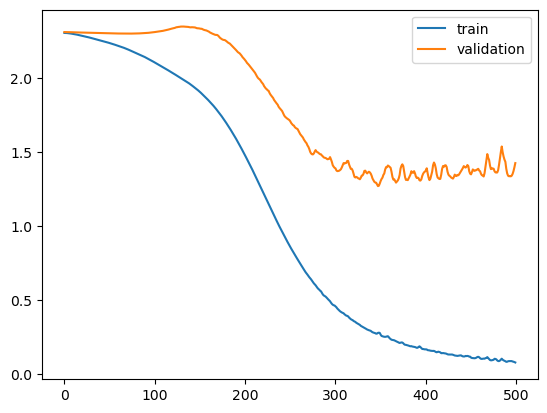

In [131]:
plt.plot(losses['train'][:500], label='train')
plt.plot(losses['val'][:500], label='validation')
plt.legend()
plt.show()

In [ ]:
def exclude_loss_plot(exp_path):
    # Opening JSON file
    with open(os.path.join(exp_path, "params.json")) as json_file:
        exp_params = json.load(json_file)
    
    # Load model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Load training and val data
    exp_training_data = torch.utils.data.Subset(all_training_data, exp_params['train_indices'])
    train_loader = torch.utils.data.DataLoader(dataset=exp_training_data,
                                               batch_size=100, 
                                               shuffle=True)
    (train_images, train_labels) = next(iter(train_loader))
    train_labels = torch.nn.functional.one_hot(train_labels, 10).to(torch.float)
    
    
    val_loader = torch.utils.data.DataLoader(dataset=validation_data,
                                             batch_size=100,
                                             shuffle=True)
    (val_images, val_labels) = next(iter(val_loader))
    val_labels = torch.nn.functional.one_hot(val_labels, 10).to(torch.float)
    
    # Find paths to saved models
    saved_models = glob.glob(os.path.join(exp_path, "models", "*"))
    saved_models.sort()
    print("Running evaluation for", len(saved_models), "models...")

    # allocate memory for losses
    losses = {
        'train': np.zeros(len(saved_models)),
        'val': np.zeros(len(saved_models))
    }
    for i, sm in enumerate(saved_models):        
        # Load weights
        model.load_state_dict(torch.load(sm, map_location=device))
        model.eval()
        
        with torch.no_grad():
            # Evaluate for training and validation
            outputs = model(train_images)
            train_loss = criterion(outputs[0], train_labels)
            losses['train'][i] = train_loss

            outputs = model(val_images)
            val_loss = criterion(outputs[0], val_labels)
            #print((np.argmax(train_labels, axis=1) == np.argmax(val_labels, axis=1)).sum())
            losses['val'][i] = val_loss

    plt.plot(losses['train'], label='train')
    plt.plot(losses['val'], label='validation')
    plt.legend()
    plt.show()
    
regular_loss_plot(exp_path)

# Ideas

It appears that there are not enough difference between training and validation sets? Really really weird if you ask me... 